# First Test

Very simple 1D model to try the integration of empymod into SimPEG.

**Limitations at this point:**

- Inversion only for infinitesimal small x-directed electric source and receiver (ab == 11)
- Frequency domain, using lagged convolution type digital linear filters
- Inversion only for resistivity ($\rho_h$), hence fixed values for anisotropy ($\lambda$), electric permeabilities ($\epsilon_h$, $\epsilon_v$) and magnetic permeabilities ($\mu_h$, $\mu_v$)
- Fixed depth structure (only inverting for layer thicknesses)
- No `numexpr`
- Numerical derivatives.

**Other considerations**

- SimPEG supports, I think, Python 2.7 and 3+, however, empymod only supports Python 3.4, 3.5, 3.6.

In [1]:
# I was playing around with this on Azure, so needed the install step
# !pip install SimPEG
# !pip install empymod

In [2]:
import numpy as np
from scipy import optimize
from copy import deepcopy as dc
import matplotlib.pyplot as plt
from scipy.constants import mu_0, epsilon_0

import SimPEG
import empymod

## 1. Forward model, create data

Lets define a simple forward model to generate some data, the canonical CSEM model (e.g., Constable and Weiss, 2006). We define only the minimum required input, and leave everything else at its default value.

### 1.1 Define model and create data

To try the most general case, let's use various frequencies and source and receiver position:

- 3 frequencies
- 2 source positions
- 4 receiver positions

The output of empymod has dimensions (nfreq, nrec, nsrc), in this case (3, 4, 2); complex valued.

As the input is a 1D model, we can still plot the data later as a function of offset only.

In [3]:
depth = np.array([ 0, 1000, 1600, 1900]) # Layer boundaries
res = np.array([2e14, .3, 1, 100, 1])    # Air, sea, overburden, target, underburden
freq = np.array([0.01, 0.1, 1.])         # 0.01, 0.1 & 1 Hz
sx = np.array([0, 500])                  # Source x-points
src = [sx, sx*0, 900]                    # Src coordinates
x = np.arange(2, 6)*1000                 # Receiver x-points
rec = [x, x*0, 1000]                     # Rec coordinates

data = empymod.dipole(src, rec, depth, res, freq, opt='spline')

# Let's also calculate a denser model
xf = np.arange(26, 106)*50       # Offsets
full = empymod.dipole([sx[0], sx[0], src[2]], [xf, xf*0, rec[2]], depth, res, freq, opt='spline')

# Ensure dimensionality, because empymod.dipole squeezes the output
if len(freq) == 1:
    data = data[None, :]
    full = full[None, :]


:: empymod END; runtime = 0:00:00.010862 :: 3 kernel call(s)


:: empymod END; runtime = 0:00:00.005288 :: 3 kernel call(s)



In [4]:
# Run some checks so the parameters have the correct shape

# Check layer parameters
model = empymod.utils.check_model(depth, res, None, None, None, None, None, False, 1)
depth, res, aniso, epermH, epermV, mpermH, mpermV, isfullspace = model

# Check frequency => get etaH, etaV, zetaH, and zetaV
freq, etaH, etaV, zetaH, zetaV = empymod.utils.check_frequency(freq, res, aniso, epermH, epermV, mpermH, mpermV, 1)

# Check src and rec
src, nsrc = empymod.utils.check_dipole(src, 'src', 1)
rec, nrec = empymod.utils.check_dipole(rec, 'rec', 1)

# Get offsets and angles (off, angle)
off, angle = empymod.utils.get_off_ang(src, rec, nsrc, nrec, 1)

### 1.2 Add some noise data

Add 5 % random error and a noise level of 1e-15 V/m.

In [5]:
# Generate noise
mask = 1e-1*(0.5 - np.random.random_sample(data.shape))
maskn = 1e-15*(0.5 - np.random.random_sample(data.shape))

# Apply noise
datan = data*(1 + mask) + maskn

### 1.3 Define plot function and plot model and data

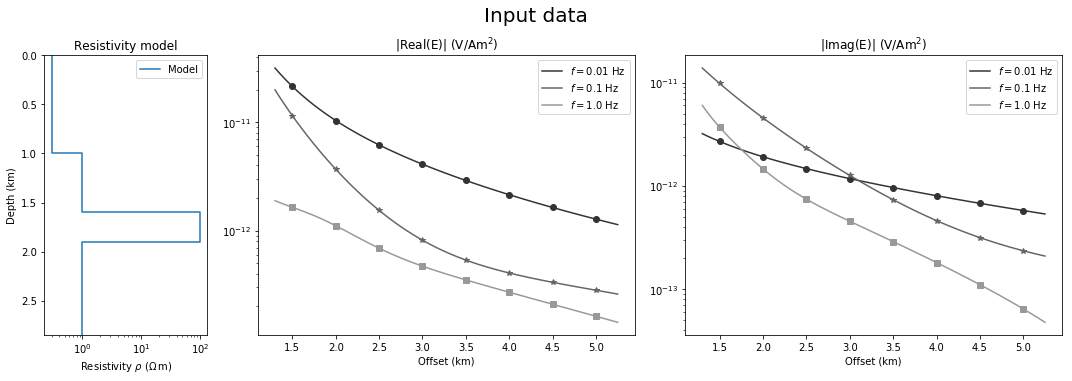

In [6]:
def plot_data(title, res, idata=None):
    # Create figure
    fig = plt.figure(figsize=(15, 5))
    plt.suptitle(title, y=1.05, fontsize=20)

    # Plot Resistivity Model
    ax0 = plt.subplot(151)
    plt.title('Resistivity model')
    plt.ylabel('Depth (km)')
    plt.xlabel(r'Resistivity $\rho\ (\Omega\,\rm{m})$')
    plt.xscale('log')
    plt.ylim([1.5*depth[-1]/1000, 0])
    
    for key, value in res.items():
        plt.plot(np.repeat(value[1][1:], 2),
                 np.r_[np.repeat(value[0][1:], 2), 1.5*value[0][-1]][1:]/1000,
                 label=key)
    plt.legend()

    # Define real subplot
    ax1 = plt.subplot2grid((1, 5), (0, 1), colspan=2)
    plt.title(r'|Real(E)| (V/Am$^2$)')
    plt.xlabel('Offset (km)')

    # Define imaginary subplot
    ax2 = plt.subplot2grid((1, 5), (0, 3), colspan=2)
    plt.title(r'|Imag(E)| (V/Am$^2$)')
    plt.xlabel('Offset (km)')

    # Loop over real, imaginary subplots
    for t, ax in enumerate([ax1, ax2]):
        # Get type
        ri_type = (np.real, np.imag)[t]

        # Activate required subplot
        plt.sca(ax)

        # Loop over frequencies
        markers = ['o', '*', 's', 'd', 'p', '+', 'x']
        for i, f in enumerate(freq):
            # Plot True model    
            plt.semilogy(xf/1000, np.abs(ri_type(full[i, :])), str(0.2+i*0.2), label='$f=$'+str(f)+' Hz')

            # Plot data
            plt.semilogy(off/1000, np.abs(ri_type(data[i, :].ravel('F'))), ls='none', marker=markers[i],
                         color=str(0.2+i*0.2))

            # Plot inversion result
            if np.any(idata):
                plt.semilogy(off/1000, np.abs(ri_type(idata[i, :].ravel('F'))), 'C3', ls='none', marker=markers[i])
                
        # Legend
        plt.legend(loc='best')

    plt.tight_layout()
    plt.show()
    
# Plot Model and input data
plot_data('Input data', {'Model': (depth, res)})

## 2. Inversion with SciPy

The main user-facing routines of `empymod` are `model.dipole` and `model.bipole`. However, they do a lot of stuff we want to avoid in an inversion scheme, such as input checks and timing.

Very rudimentary test with `SciPy`. Misses regularization, weighting, basically everything. Just out of interest.

It seems to work well only with very few layers. Too much freedom and it goes off...

In [7]:
# Define the inversion model: 20 layers, plus air, sea, and lower half-space
idepth = np.r_[-np.infty, 0, 1000+np.arange(6)*300] 

# Initial resistivities (starting model resistivity)
sres = np.ones(idepth.shape)
sres[:2] = [2e14, 0.3]  # Air and water resistivity
ires = dc(sres)

# Calc zeta (isotropic)
zeta = np.outer(2j*np.pi*freq, np.ones(sres.shape)*mu_0)

# Model parameters which we do not invert for (at the moment, at least)
fixed_params = {
    'zsrc': np.array(src[2]),
    'zrec': np.array(rec[2]),
    'lsrc': 1,
    'lrec': 1,
    'off': off,
    'angle': angle,
    'depth': idepth,
    'ab': 11,            # El., x-directed source and receivers
    'freq': freq,
    'zetaH': zeta,
    'zetaV': zeta,
    'msrc': False,       # Electric source
    'mrec': False,       # Electric receivers
}

# Stuff we don't touch at the moment and keep fixed
settings = {
    'isfullspace': False,
    'xdirect': False,                                 # Direct field in the wavenumber domain
    'ht': 'fht',                                      # FHT (digital linear filter)
    'htarg': (empymod.filters.key_201_2009(), None),  # Default FHT arguments
    'use_spline': True,                               # Lagged convolution
    'use_ne_eval': False,                             # Do not use `numexpr`
    'loop_freq': True,                                # If use_spline=True, loop_freq has to be True too
    'loop_off': False,
    'conv': True
}


# Define a simple routine to calculate one forward model based only on resistivity
def calc_fm(res, fixed_params=fixed_params, settings=settings):

    # Calculate eta (isotropic)
    eta = 1/res + np.outer(2j*np.pi*freq, np.ones(res.shape)*epsilon_0)
    
    # Calculate result
    out, _, _ = empymod.model.fem(etaH=eta, etaV=eta, **fixed_params, **settings)
    
    return out.reshape((-1, nrec, nsrc), order='F')


def cost_fct(invres, dat):
    """Cost function, very crude implementation."""
    # Calculate eta (isotropic); first three and last layers fixed
    thisres = np.r_[2e14, 0.3, 1, 10**invres, 1]
    eta = 1/thisres + np.outer(2j*np.pi*freq, np.ones(thisres.shape)*epsilon_0)

    # Calculate result
    out, _, _ = empymod.model.fem(etaH=eta, etaV=eta, **fixed_params, **settings)
    out = np.squeeze(out.reshape((-1, nrec, nsrc), order='F'))

    # Very crude minimization function, no weighting whatsoever; assuming 1 % data error
    out = np.sum(((np.real(dat)-np.real(out))**2 + (np.imag(dat)-np.imag(out))**2)/np.abs(dat*.01)**2)

    return out


def dcost_fct(invres, dat):
    """Calculate gradient of the cost function, very basic implementation too."""

    resdiff = 1e-3  # Difference to calculate gradient
    
    # Pre-allocate
    out = np.zeros(invres.shape)
    
    # Loop over free layers
    for i, val in enumerate(invres):
        pres = dc(invres)
        mres = dc(invres)
        pres[i] = val + resdiff
        mres[i] = val - resdiff
        out[i] = (cost_fct(pres, dat) - cost_fct(mres, dat))/(2*resdiff)
        
    return out

In [8]:
# Try BFGS; first three and last layers fixed
ires = 10**optimize.fmin_bfgs(cost_fct, np.log10(sres[3:-1]), dcost_fct, (datan,))

# Calculate final model
ires = np.r_[2e14, 0.3, 1, ires, 1]
scipyinv = calc_fm(ires)

         Current function value: 208.751108
         Iterations: 94
         Function evaluations: 193
         Gradient evaluations: 181


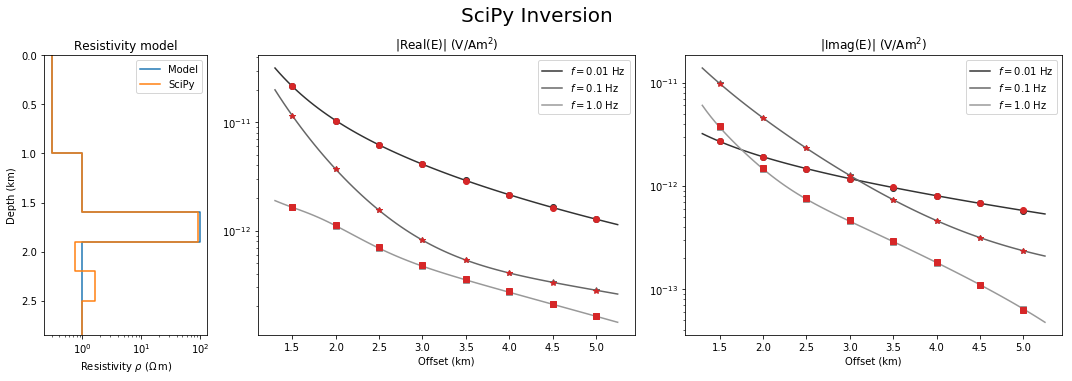

In [9]:
plot_data('SciPy Inversion', {'Model': (depth, res), 'SciPy': (idepth, ires)}, scipyinv)

## 3.  SimPEG wrapper class for an empymod problem

In [10]:
# this is sketching out an idea for later... we can chat! 

# import properties

# class EmpymodParameters(properties.HasProperties):
    
#     zsrc = properties.Array("z location of the source", default=np.r_[10])

In [11]:
from SimPEG.Problem import BaseProblem
from SimPEG import Props

class EmpymodProblem(BaseProblem):
    """
    Problem class for a simulation conducted with empymod
    """
    
    rho, rho_map, rho_deriv = Props.Invertible(
        "Electrical Resistivity (Ohm m)"
    ) 
    
    deleteTheseOnModelUpdate = ['_Japprox']
    
    # Stuff we don't touch at the moment and keep fixed
    empymod_settings = {
        'isfullspace': False,
        'xdirect': False,                                 # Direct field in the wavenumber domain
        'ht': 'fht',                                      # FHT (digital linear filter)
        'htarg': (empymod.filters.key_201_2009(), None),  # Default FHT arguments
        'use_spline': True,                               # Lagged convolution
        'use_ne_eval': False,                             # Do not use `numexpr`
        'loop_freq': True,                                # If use_spline=True, loop_freq has to be True too
        'loop_off': False,
        'conv': True
    }
    
    def __init__(self, mesh, **kwargs):
        assert mesh.dim == 1, "only 1D modelling supported"
        super(EmpymodProblem, self).__init__(mesh, **kwargs)
        
        # set air at infinity
        depth = self.mesh.gridN.copy()
        depth[0] = -np.inf
        
        # set the empymod_fixedparams
        zeta = np.outer(2j*np.pi*freq, np.ones(depth.shape)*mu_0)
        self.fixed_params = {
            'zsrc': np.array(src[2]),
            'zrec': np.array(rec[2]),
            'lsrc': 1,
            'lrec': 1,
            'off': off,
            'angle': angle,
            'depth': depth,
            'ab': 11,            # El., x-directed source and receivers
            'freq': freq,
            'zetaH': zeta,
            'zetaV': zeta,
            'msrc': False,       # Electric source
            'mrec': False,       # Electric receivers
        }
    
    def _calc_fm(self, rho):
        """
        compute data using empymod. The real and imaginary parts are separated so that 
        we are always working with real values
        """
        
        # Calculate eta (isotropic)
        eta = 1/rho + np.outer(2j*np.pi*freq, np.ones(rho.shape)*epsilon_0)
        
        # Calculate result
        out, _, _ = empymod.model.fem(etaH=eta, etaV=eta, **self.fixed_params, **self.empymod_settings)
        out = np.ravel(out, order='F')
        stackout = np.hstack([out.real, out.imag])
        return stackout
    
    def fields(self, m):
        """
        Computes the fields
        """
        
        # set the model (this performs the mappings)
        self.model = m
        return self._calc_fm(self.rho)
    
    def Japprox(self, m, perturbation=0.1, min_perturbation=1e-3):
        """
        Approximate sensitivity computed using a finite difference approach
        """
        if getattr(self, '_Japprox', None) is None:
            self.model = m 
            delta_m = min_perturbation # np.max([perturbation*m.mean(), min_perturbation])

            J = []

            for i, entry in enumerate(m):
                mpos = m.copy()
                mpos[i] = entry + delta_m
                
                mneg = m.copy()
                mneg[i] = entry - delta_m
                
                pos = self._calc_fm(self.rho_map * mpos)
                neg = self._calc_fm(self.rho_map * mneg)
                J.append((pos - neg) / (2.*delta_m))

            self._Japprox = np.vstack(J).T
            
        return self._Japprox
    
    def Jvec(self, m, v, f=None):
        """
        Sensitivity times a vector
        """
        self.model = m
        return self.Japprox(m).dot(v)

    def Jtvec(self, m, v, f=None):
        """
        Adjoint Sensitivity times a vector
        """
        self.model = m
        return self.Japprox(m).T.dot(v)

    
class EmpymodSurvey(SimPEG.Survey.BaseSurvey):
    """
    Survey class for a simulation conducted with empymod
    """
    
    @property 
    def nD(self):
        # this will likely need to be generalized
        return len(self.prob.fixed_params['off']) * len(self.prob.fixed_params['freq']) * 2

    def eval(self, f):
        return f

def re_field(inp):
    inp = inp.reshape(2, -1)
    inp = inp[0, :] + 1j*inp[1, :]
    return inp.reshape((-1, nrec, nsrc), order='F')

## Tests
- **forward** make sure we can reproduce initial results
- **Jvec** test sensitivity computation

In [12]:
# this is something we can work on cleaning up - simpeg needs a mesh for the forward problem,
# working with infinity is tricky, so I make it finite here and swap it out for an inf in 
# the instantiation of the problem 

finite_air_z = 1000
true_depth = depth[1:].copy()
true_depth = np.hstack([np.r_[-finite_air_z], true_depth])
meshfwd = SimPEG.Mesh.TensorMesh([np.diff(true_depth)], x0=[-finite_air_z])

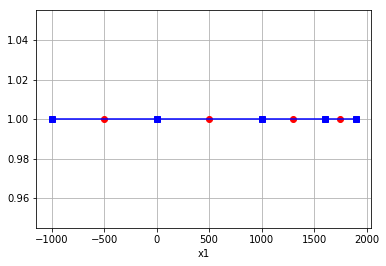

In [13]:
# plot the mesh
meshfwd.plotGrid(nodes=True, centers=True)

Here, we set up mappings - we will invert for log(resistivity) below the sea floor

In [14]:
# for the inversion, we want to ignore air and probably the sea layers
# and invert for log-resistivity 

exp_map_fwd = SimPEG.Maps.ExpMap(nP=len(res))
inject_active_cells_fwd = SimPEG.Maps.InjectActiveCells(
    meshfwd, 
    np.arange(2, len(res)),  # active indices (eg layers we want to invert for)
    np.log(res[:2]),  # log-resistivity values of the inactive cells
    nC=len(res)
)

In [15]:
# create the problem object
probfwd = EmpymodProblem(meshfwd, rho_map=exp_map_fwd * inject_active_cells_fwd)

In [16]:
# start with the true model and compute data 

m = np.log(res[2:])
fields = probfwd.fields(m)

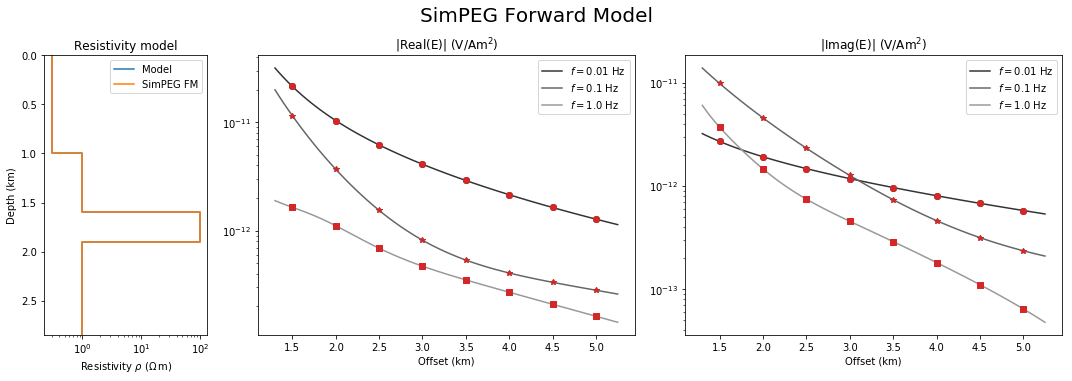

In [17]:
plot_data('SimPEG Forward Model', {'Model': (depth, res), 'SimPEG FM': (depth, probfwd.rho)}, (re_field(fields)))

## Test the sensitivities

Work with a 20 layer model, check that the sensitivities are second order

In [18]:
from SimPEG import Tests

In [19]:
finite_air_z = 1000
seafloor = depth[2]
nlayers = 21
last_layer = 2500  # depth of last layer

h = (last_layer-seafloor)/nlayers  # layer thicknesses

# create a mesh
inversion_depths = np.hstack([
    np.r_[-finite_air_z, 0.], 
    np.arange(seafloor, last_layer+h, h)
])

simpeg_depths = np.diff(inversion_depths)
mesh = SimPEG.Mesh.TensorMesh([simpeg_depths], x0=[-finite_air_z])

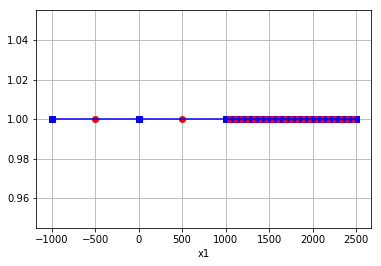

In [20]:
mesh.plotGrid(nodes=True, centers=True)

In [21]:
# mappings and problem 

exp_map = SimPEG.Maps.ExpMap(nP=nlayers+3)
inject_active_cells = SimPEG.Maps.InjectActiveCells(
    mesh, 
    2+np.arange(0, nlayers+1),  # active indices (eg layers we want to invert for)
    np.log(ires[:2]),  # log-resistivity values of the inactive cells
    nC=nlayers+3
)

prob = EmpymodProblem(mesh, rho_map=exp_map * inject_active_cells)

In [22]:
# m0 = np.random.rand(nlayers+1)
m0 = np.zeros(nlayers+1)
def function_and_deriv(x):   
    return prob.fields(x), lambda v: prob.Jvec(m0, v)

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    5.827e-13     4.979e-14      nan
 1   1.00e-02    6.022e-14     5.208e-16      1.980
 2   1.00e-03    6.044e-15     5.234e-18      1.998
 3   1.00e-04    6.046e-16     5.241e-20      1.999
 4   1.00e-05    6.047e-17     5.289e-22      1.996
 5   1.00e-06    6.047e-18     6.055e-24      1.941
========================= PASS! =========================
You deserve a pat on the back!



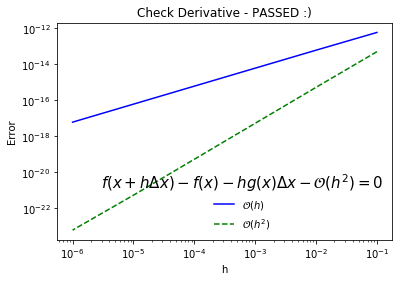

True

In [23]:
Tests.checkDerivative(function_and_deriv, x0=m0, num=6, expectedOrder=2)

In [24]:
# Test Adjoint
u = prob.fields(m0)

v = np.random.rand(len(u))
w = np.random.rand(len(m0))

vJw = v.dot(prob.Jvec(m0, w))
wJtv = w.dot(prob.Jtvec(m0, v))

print(vJw, wJtv, vJw - wJtv)

-4.24558704311e-13 -4.24558704311e-13 -1.00974195868e-28


## Invert 

- Use a 20 layer model, starting model and reference model of log(1 Ohm m) 
- we will invert the clean data for now
- assign a 5% error and a 5e-15 floor so that we don't over-fit the zero-crossings

In [25]:
survey = EmpymodSurvey()
survey.pair(prob)

In [26]:
rdata = np.ravel(datan, order='F')
survey.dobs = np.hstack([rdata.real, rdata.imag])  # observed data
survey.std = np.abs(survey.dobs)*.05
survey.eps = 5e-15

In [27]:
# regularization
reg = SimPEG.Regularization.Simple(
    SimPEG.Mesh.TensorMesh([len(m0)]), alpha_s=5e-5, alpha_x=1, mref=np.zeros(nlayers+1)
)

# data misfit
dmis = SimPEG.DataMisfit.l2_DataMisfit(survey)

# optimization
opt = SimPEG.Optimization.InexactGaussNewton(maxIter=40)

# inverse problem
invProb = SimPEG.InvProblem.BaseInvProblem(dmis, reg, opt, beta=5)

# directives 
target = SimPEG.Directives.TargetMisfit()
directives = [
#     SimPEG.Directives.BetaEstimate_ByEig(beta0_ratio=5e-2),
    target
]

# inversion
inv = SimPEG.Inversion.BaseInversion(invProb, directiveList=directives)

In [28]:
m0 = np.zeros(nlayers+1) # starting model

In [29]:
# run the inversion 
mrec = inv.run(m0)


    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.00e+00  3.37e+03  0.00e+00  3.37e+03    7.59e+02      0              
   1  5.00e+00  2.43e+03  1.30e-04  2.43e+03    2.60e+02      0              
   2  5.00e+00  1.53e+03  5.63e-01  1.53e+03    5.93e+02      0              
   3  5.00e+00  1.37e+03  4.15e+00  1.39e+03    2.46e+03      0   Skip BFGS  
   4  5.00e+00  9.93e+02  7.36e+00  1.03e+03    1.45e+03      0              
   5  5.00e+00  2.51e+02  5.27e+00  2.77e+02    8.99e+02      0              
   6  5.00e+00  2.26e+02  5.22e+00  2.52e+02    8.25e+02      3   Skip BFGS  
   7  5.00e+00  2.02e+02  5.74e+00  2.31e+

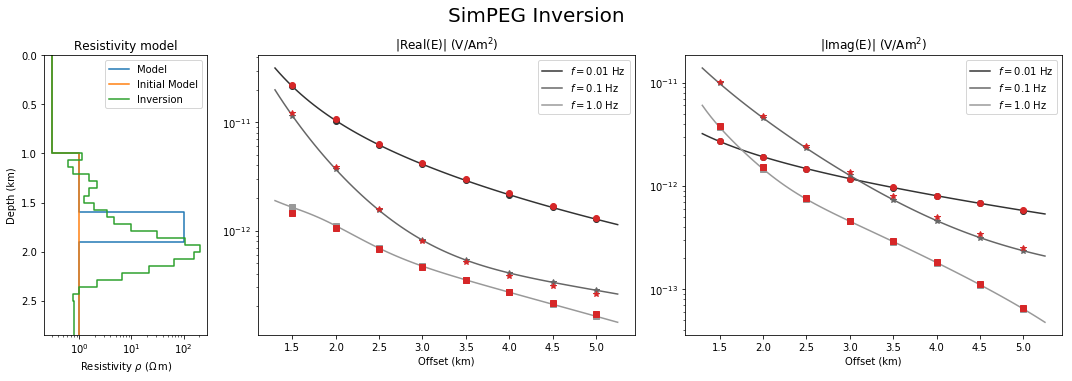

In [30]:
plot_data('SimPEG Inversion',
          {'Model': (depth, res),
           'Initial Model': (mesh.gridN, prob.rho_map*m0),
           'Inversion': (mesh.gridN, prob.rho_map*mrec)},
          (re_field(prob.fields(mrec))))

In [31]:
import printinfo
printinfo.info()